In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf

#seasonal plot functie
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

#periodogram laat zien in hoeverre er seasonality in de dataset zit
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)




In [2]:
#data inlezen en gemiddelde sales per dag pakken
df = pd.read_csv(
    "data/train.csv"
    , parse_dates=['date']
    , infer_datetime_format=True)
df = df.set_index('date').to_period('D')
df = df.set_index(['store_nbr', 'family'], append=True)
average_sales = df.groupby('date').mean()[['sales', 'onpromotion']]


#opvullen lege data 
idx = pd.date_range('2013-01-01', '2017-08-15')
average_sales.index = average_sales.index.to_timestamp()
average_sales = average_sales.reindex(idx, fill_value=0)
average_sales.index = average_sales.index.to_period("D")

average_sales.index = average_sales.index.rename("date")


#target isoleren
y = average_sales["sales"]


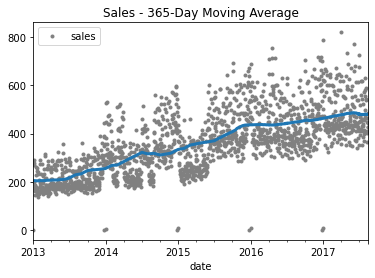

In [3]:
#--------TREND--------

#trendlijn bepalen op basis van bekende data:

moving_average = average_sales[['sales']].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=180,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = average_sales[['sales']].plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Sales - 365-Day Moving Average", legend=False,
);

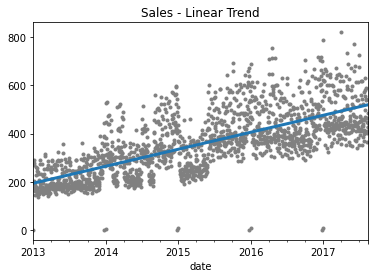

In [4]:
#trend feature toevoegen die het beste past bij de bepaalde lijn
#met Deterministic function (zelfde als Time, maar dan met meer opties)

from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X_trend = dp.in_sample()

#Trend leren op basis van Deterministic
from sklearn.linear_model import LinearRegression


# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X_trend, y)

y_trend_pred = pd.Series(model.predict(X_trend), index=X_trend.index)

#geleerde trend bekijken
ax = y.plot(style=".", color="0.5", title="Sales - Linear Trend")
_ = y_trend_pred.plot(ax=ax, linewidth=3, label="Trend")

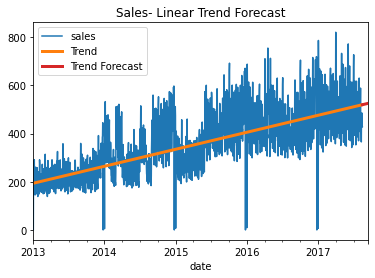

In [5]:
#trend forecasten
X_trend_fore = dp.out_of_sample(steps=30)
y_trend_fore = pd.Series(model.predict(X_trend_fore), index=X_trend_fore.index)

#trend forecast bekijken
ax = y.plot(title="Sales- Linear Trend Forecast")
ax = y_trend_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_trend_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

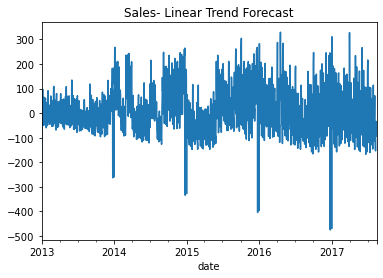

In [6]:
#detrenden
y_detrended = y - y_trend_pred
ax = y_detrended.plot(title="Sales- Linear Trend Forecast")


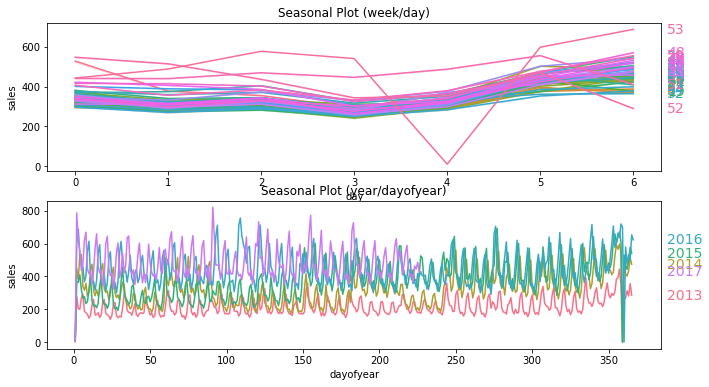

In [7]:
#--------SEASONAL--------

average_sales['day'] = average_sales.index.dayofweek
average_sales['week'] = average_sales.index.week

average_sales["dayofyear"] = average_sales.index.dayofyear
average_sales["year"] = average_sales.index.year

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(average_sales, y="sales", period="week", freq="day", ax=ax0)
seasonal_plot(average_sales, y="sales", period="year", freq="dayofyear", ax=ax1);

C:\Users\Tijs\AppData\Local\Temp/ipykernel_6532/4044054029.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  plot_periodogram(average_sales.sales);


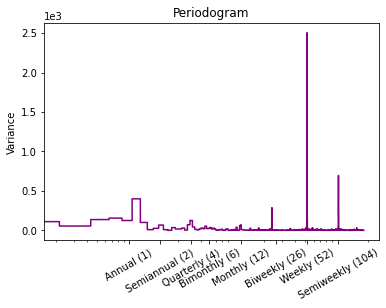

In [8]:
plot_periodogram(average_sales.sales);

In [9]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="M", order=6)  

dp = DeterministicProcess(
    index=average_sales.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X_trend_season = dp.in_sample()

In [10]:
model = LinearRegression(fit_intercept=False)
model.fit(X_trend_season, y)

y_pred_trend_season = pd.Series(model.predict(X_trend_season), index=X_trend_season.index)



X_trend_season_fore = dp.out_of_sample(steps=180)
y_trend_season_fore = pd.Series(model.predict(X_trend_season_fore), index=X_trend_season_fore.index)



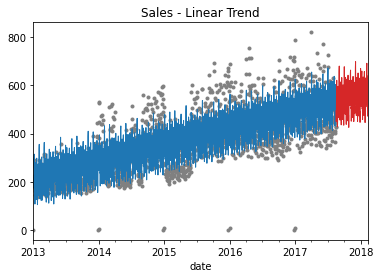

In [11]:
ax = y.plot(style=".", color="0.5", title="Sales - Linear Trend")
ax = y_pred_trend_season.plot(ax=ax, linewidth=1, label="Trend")
ax = y_trend_season_fore.plot(ax=ax, linewidth=1, label="Trend Forecast", color="C3")

C:\Users\Tijs\AppData\Local\Temp/ipykernel_6532/3486588241.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax1 = plot_periodogram(y, ax=ax1)
C:\Users\Tijs\AppData\Local\Temp/ipykernel_6532/3486588241.py:6: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version
  ax2 = plot_periodogram(y_detrend_deseason, ax=ax2);


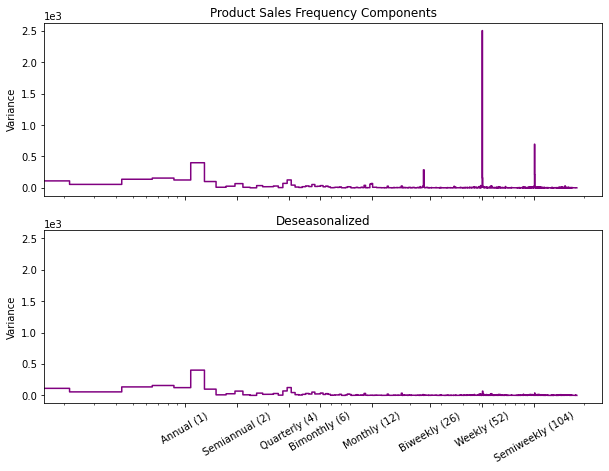

In [12]:
y_detrend_deseason = y - y_pred_trend_season

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_detrend_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [13]:
#-------TIME FEATURES------------------
#Holidays
holidays_events = pd.read_csv("data/holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')


#holidays split pred en forecasting
holidays_pred = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2013':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)


holidays_fore = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017-08-15':'2018-02-11', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)


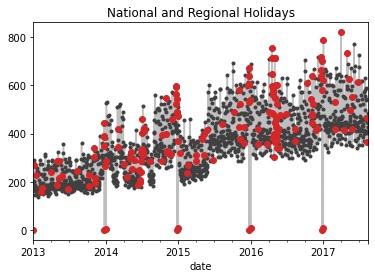

In [14]:
#Time Features plotten
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
plt.plot_date(holidays_pred.index, y[holidays_pred.index], color='C3')
ax.set_title('National and Regional Holidays');

In [15]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')

#OH holidays voor in training set
OH_holidays_pred = pd.DataFrame(
    ohe.fit_transform(holidays_pred),
    index=holidays_pred.index,
    columns=holidays_pred.description.unique(),  # optional,  but nice to have
)

X_holidays_pred = average_sales.join(OH_holidays_pred, on='date').fillna(0.0)

#OH holidays voor in forecasting set
X_holidays_fore = pd.DataFrame(
    ohe.transform(holidays_fore),
    index=holidays_fore.index,
    columns=ohe.categories_[0]
)

#compenseren voor de extra regels met holidays
y_holidays = X_holidays_pred.loc[:, 'sales']  # target
y_holidays, X_holidays_pred = y_holidays.align(X_holidays_pred, join='inner')



In [16]:
#model trainen met trend, seasons & holidays
X_trend_season_holidays = X_holidays_pred.join(X_trend_season, on='date').fillna(0.0)
X_trend_season_holidays['NewYear'] = (X_trend_season_holidays.index.dayofyear == 1)
y_trend_season_holidays = X_trend_season_holidays.pop('sales')  # target
y_trend_season_holidays, X_trend_season_holidays = y_trend_season_holidays.align(X_trend_season_holidays, join='inner')

model = LinearRegression(fit_intercept=False)
model.fit(X_trend_season_holidays, y_trend_season_holidays)
y_trend_season_holidays_pred = pd.DataFrame(model.predict(X_trend_season_holidays), index=X_trend_season_holidays.index)


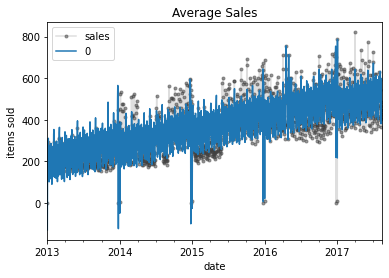

In [17]:
#getrainde model bekijken op bestaande data
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_trend_season_holidays_pred.plot(ax=ax, label="Seasonal")
ax.legend();

In [18]:
#voorbereiden forecast set
X_trend_season_holidays_fore = dp.out_of_sample(180)
X_trend_season_holidays_fore['NewYear'] = (X_trend_season_holidays_fore.index.dayofyear == 1)
X_trend_season_holidays_fore.index = X_trend_season_holidays_fore.index.rename("date")
X_trend_season_holidays_fore["onpromotion"] = 0.0 #issue, we weten de onpromotion in de toekomst nog niet (wel in comp set)
X_trend_season_holidays_fore['day'] = X_trend_season_holidays_fore.index.dayofweek
X_trend_season_holidays_fore['week'] = X_trend_season_holidays_fore.index.week
X_trend_season_holidays_fore["dayofyear"] = X_trend_season_holidays_fore.index.dayofyear
X_trend_season_holidays_fore["year"] = X_trend_season_holidays_fore.index.year
#One Hotted holidays toevoegen aan de forecast set
X_trend_season_holidays_fore = X_trend_season_holidays_fore.join(X_holidays_fore, on='date').fillna(0.0)


In [19]:
#kolomvolgorde gelijk zetten aan de training set, anders gaat je model omver
X_trend_season_holidays_fore = X_trend_season_holidays_fore.reindex(columns=X_trend_season_holidays.columns)
y_trend_season_holidays_fore = pd.Series(model.predict(X_trend_season_holidays_fore), index=X_trend_season_holidays_fore.index)

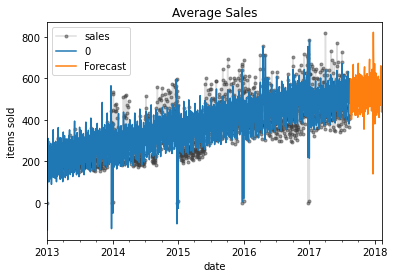

In [20]:
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_trend_season_holidays_pred.plot(ax=ax, label="Seasonal fit")
ax = y_trend_season_holidays_fore.plot(ax=ax, label="Forecast")
ax.legend();

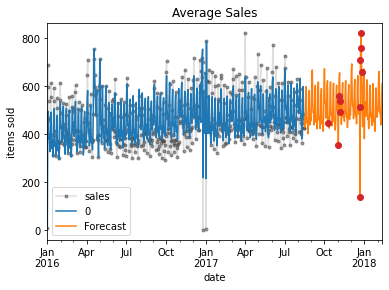

In [21]:
ax = y.loc['2016':].plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_trend_season_holidays_pred.loc['2016':].plot(ax=ax, label="Seasonal fit")
ax = y_trend_season_holidays_fore.loc['2016':].plot(ax=ax, label="Forecast")
plt.plot_date(holidays_fore.index, y_trend_season_holidays_fore[holidays_fore.index], color='C3')
ax.legend();

In [22]:
y.to_frame().shape

(1688, 1)

In [23]:
y_trend_season_holidays_pred[0]

date
2013-01-01   -130.315925
2013-01-02    217.068414
2013-01-03    165.490063
2013-01-04    189.482097
2013-01-05    267.873244
                 ...    
2017-08-11    468.675271
2017-08-12    565.623590
2017-08-13    598.731612
2017-08-14    475.928372
2017-08-15    462.511826
Freq: D, Name: 0, Length: 1693, dtype: float64

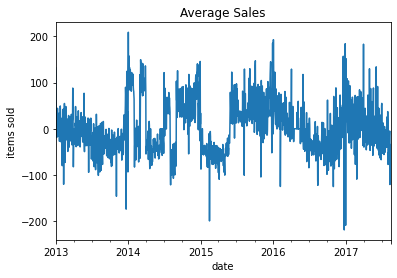

In [24]:
#variance zonder trend, seasons en holiday features
y_detrend_deseason_deholiday = y - y_trend_season_holidays_pred[0]
y_detrend_deseason_deholiday.name = 'sales_de-alles'

ax = y_detrend_deseason_deholiday.plot( title="Average Sales", ylabel="items sold")

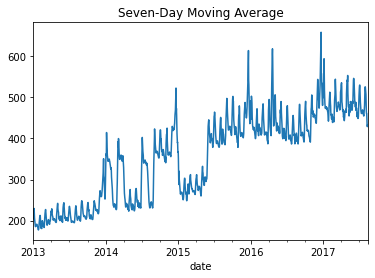

In [25]:
# YOUR CODE HERE
y_ma = y.rolling(window=7,center=True).mean()


# Plot
ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");







C:\Users\Tijs\anaconda3\envs\TS\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


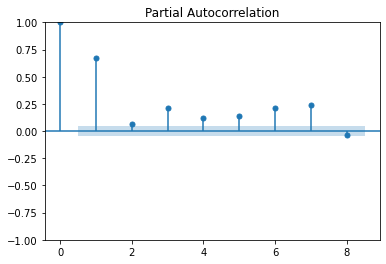

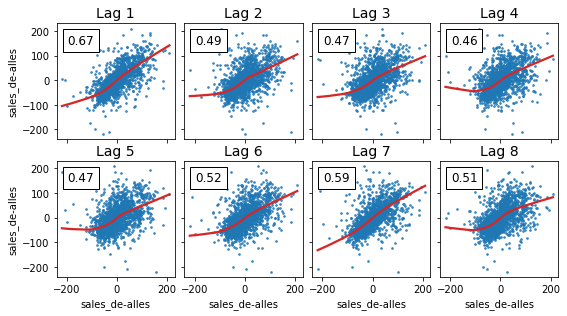

In [33]:
#--------LAGS---------
#Features op basis van historie "als ik gisteren dit heb verkocht, dan verkoop ik vandaag waarschijnlijk..."
plot_pacf(y_detrend_deseason_deholiday, lags=8);
plot_lags(y_detrend_deseason_deholiday, lags=8, nrows=2);

In [35]:
#7 lags lijken relevant, dus toevoegen aan de featureset!
X_lags = make_lags(y_detrend_deseason_deholiday, lags=7)

In [36]:
 = pd.concat([X_trend_season_holidays, X_lags], axis=1).dropna()
y, X_trend_season_holidays_lags = y.align(X_trend_season_holidays_lags, join='inner')

In [53]:
#kijken of promotie nog relevant is!

onpromotion = X_trend_season_holidays.loc[:, 'onpromotion'].squeeze().rename('onpromotion')
onpromotion

date
2013-01-01    0.000000
2013-01-02    0.000000
2013-01-03    0.000000
2013-01-04    0.000000
2013-01-05    0.000000
                ...   
2017-08-11    7.956790
2017-08-12    4.664422
2017-08-13    5.209315
2017-08-14    4.513468
2017-08-15    5.951178
Freq: D, Name: onpromotion, Length: 1693, dtype: float64

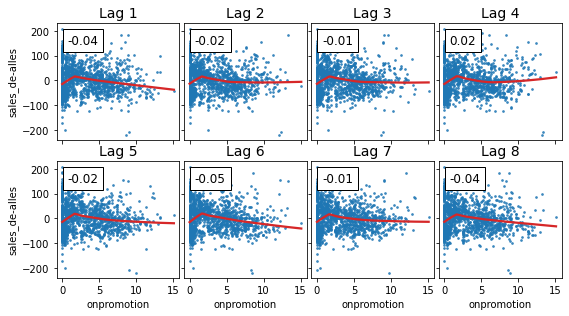

In [55]:
#niet echt dus
plot_lags(x=onpromotion.iloc[1:], y=y_detrend_deseason_deholiday.iloc[1:], lags=8, nrows=2);

Training RMSLE: 0.22138
Validation RMSLE: 0.07758


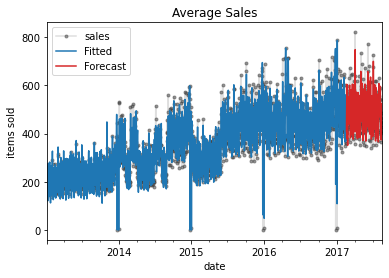

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
X_train, X_valid, y_train, y_valid = train_test_split(X_trend_season_holidays_lags, y, test_size=180, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')
    
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();